In [1]:
import scipy.io
import scipy.io
import anndata
import pandas as pd
import numpy as np

In [2]:
import networkx as nx
import scanpy as sc
import scglue
from matplotlib import rcParams
from itertools import chain
import itertools
import seaborn as sns

/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# reading data
sparse_matrix = scipy.io.mmread("data/rna_sparse_matrix.mtx")
sparse_matrix = scipy.sparse.csr_matrix(sparse_matrix)

In [4]:
# reading peak name and gene name
gene_names = pd.read_csv("data/gene_names.csv", header=None)[1].tolist()
cell_names = pd.read_csv("data/cell_names.csv", header=None)[1].tolist()
gene_names = gene_names[1:]
cell_names = cell_names[1:]

In [5]:
rna_adata = anndata.AnnData(sparse_matrix.T)

rna_adata.var_names = gene_names
rna_adata.obs_names = cell_names

In [6]:
rna_adata.layers["counts"] = rna_adata.X.copy()

/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


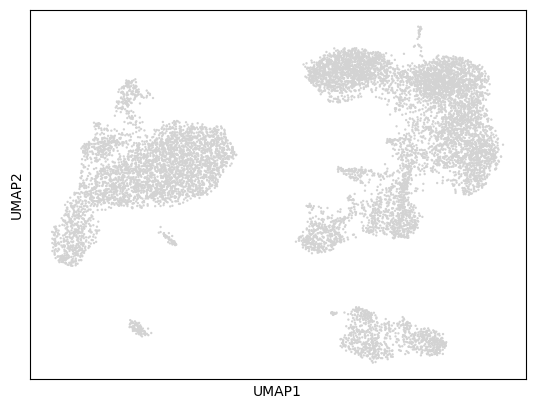

In [7]:
# data processing (RNA)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.scale(rna_adata)
sc.tl.pca(rna_adata, n_comps=100, svd_solver="auto")
sc.pp.neighbors(rna_adata, metric="cosine")
sc.tl.umap(rna_adata)
sc.pl.umap(rna_adata)

In [2]:
## ATAC
atac_matrix = scipy.io.mmread("data/atac_sparse_matrix.mtx")
atac_matrix = scipy.sparse.csr_matrix(atac_matrix)
peak_names = pd.read_csv("data/peak_names.csv", header=None)[1].tolist()
cell_names = pd.read_csv("data/atac_cell_names.csv", header=None)[1].tolist()
peak_names = peak_names[1:]
cell_names = cell_names[1:]

NameError: name 'scipy' is not defined

In [9]:
atac_adata = anndata.AnnData(atac_matrix.T)
atac_adata.var_names = peak_names
atac_adata.obs_names = cell_names

/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


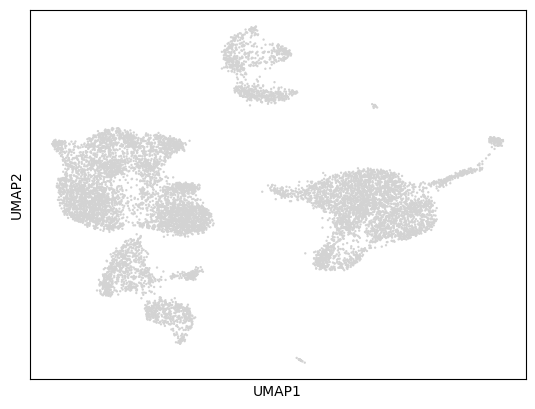

In [10]:
##ATAC precessing
scglue.data.lsi(atac_adata, n_components=50, n_iter=15)
sc.pp.neighbors(atac_adata, use_rep="X_lsi", n_pcs=50)
sc.tl.umap(atac_adata)
sc.pl.umap(atac_adata)

In [11]:
# obtain genomic coordinates
scglue.data.get_gene_annotation(
    rna_adata, gtf="refdata-gex-GRCh38-2020-A/genes/genes.gtf",
    gtf_by="gene_name")

In [12]:
rna_adata.var.loc[:, ["chrom", "chromStart", "chromEnd"]]

,chrom,chromStart,chromEnd
MIR1302-2HG,chr1,29553.0,31109.0
FAM138A,chr1,34553.0,36081.0
OR4F5,chr1,65418.0,71585.0
AL627309.1,chr1,89294.0,133723.0
AL627309.3,chr1,89550.0,91105.0
...,...,...,...
AC141272.1,KI270728.1,1270983.0,1271271.0
AC023491.2,KI270731.1,10597.0,13001.0
AC007325.1,KI270734.1,72410.0,74814.0
AC007325.4,KI270734.1,131493.0,137392.0


In [13]:
split = atac_adata.var_names.str.split(r"[:-]")
atac_adata.var["chrom"] = split.map(lambda x: x[0])
atac_adata.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac_adata.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac_adata.var.head()


,chrom,chromStart,chromEnd
chr1-9790-10675,chr1,9790,10675
chr1-180599-181702,chr1,180599,181702
chr1-191168-192093,chr1,191168,192093
chr1-267565-268455,chr1,267565,268455
chr1-270876-271770,chr1,270876,271770


In [14]:
rna_adata.var = rna_adata.var.fillna(0)
rna_adata.var.loc[~rna_adata.var['strand'].isin(['+', '-']), 'strand'] = '+'

In [15]:
#Graph construction
guidance = scglue.genomics.rna_anchored_guidance_graph(rna_adata, atac_adata)
guidance

window_graph: 100%|██████████| 36601/36601 [00:02<00:00, 16534.32it/s]


In [16]:
scglue.graph.check_graph(guidance, [rna_adata, atac_adata])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [17]:
atac_adata.var.head()

,chrom,chromStart,chromEnd,highly_variable
chr1-9790-10675,chr1,9790,10675,False
chr1-180599-181702,chr1,180599,181702,False
chr1-191168-192093,chr1,191168,192093,False
chr1-267565-268455,chr1,267565,268455,False
chr1-270876-271770,chr1,270876,271770,False


In [ ]:
scglue.models.configure_dataset(
rna_adata, "NB", use_highly_variable=True,
use_layer="counts", use_rep="X_pca")
scglue.models.configure_dataset(
atac_adata, "NB", use_highly_variable=True,
use_rep="X_lsi")
    
guidance_hvf = guidance.subgraph(chain(
rna_adata.var.query("highly_variable").index,
atac_adata.var.query("highly_variable").index)).copy()
    
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_adata, "atac": atac_adata}, guidance_hvf,
    fit_kws={"directory": "glue"})
dx = scglue.models.integration_consistency(
    glue, {"rna": rna_adata, "atac": atac_adata}, guidance_hvf)

    
rna_adata.obsm["X_glue"] = glue.encode_data("rna", rna_adata)
atac_adata.obsm["X_glue"] = glue.encode_data("atac", atac_adata)
combined = anndata.concat([rna_adata, atac_adata])
    
combined.obs['domain'] = ''
num = int(combined.obs.shape[0]/2)
combined.obs.iloc[:num, combined.obs.columns.get_loc('domain')] = 'RNA'
combined.obs.iloc[num+1:, combined.obs.columns.get_loc('domain')] = 'ATAC'
res_df = pd.DataFrame(combined.obsm['X_glue'],index=combined.obs.index)
res_df['domain'] = combined.obs['domain']
res_df.to_csv('glue_embed', index_label='RowName', header=True)


/dssg/home/acct-clswt/clswt-chaodeng/miniconda3/envs/glue/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


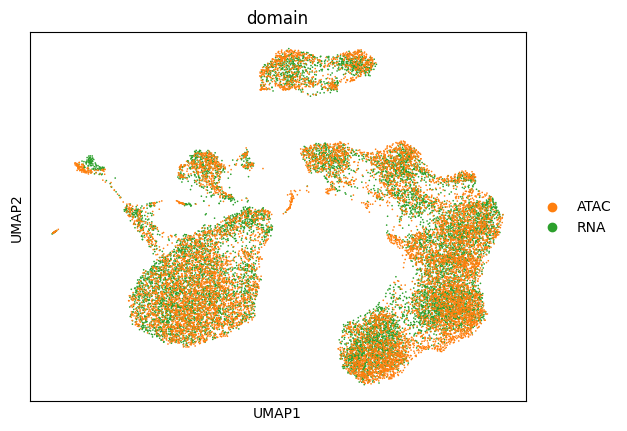

In [26]:
sc.pp.neighbors(combined, use_rep="X_glue")
sc.tl.umap(combined)
sc.pl.umap(combined, color=["domain"], wspace=0.65)